# River bifurcation in CONUS workflow
This notebook contains the workflow necessary to extract data from a HUC4 and join it to NABD for bifurcation analysis.

## 1. Install packages

In [1]:
# import sys
# !{sys.executable} -m pip install geofeather
# !{sys.executable} -m pip install nhdnet  #see Setup info document 

## 2. Load modules

In [2]:
# Basic analysis 
from pathlib import Path
import os
from time import time
import geopandas as gp
import geofeather
import numpy as np
import pandas as pd

# Set path
gdrive = Path("/Volumes/GoogleDrive/My Drive/Condon_Research_Group/Research_Projects/Rachel/Research/GIS/Layers") # where shapefiles live on the Drive

## 3. Read in the sample geodatabase

### 3.1 Read in the HUC4 shapefile (1019) I made 

In [13]:
flowlines_test = gp.read_file(gdrive/"HUC_test/Test1029.shp")       # this is actually HUC 1019
flowlines_test = flowlines_test.rename(columns={"REACHCODE": "Reachcode"})  # rename columns  
flowlines_test = flowlines_test.rename(columns={"StreamOrde": "streamorder"})
# print(flowlines_test)
# list(flowlines_test.columns)

### 3.2 Checks and cleanup of 'flowlines_test'

        OBJECTID      COMID       Reachcode  streamorder  \
0      1518650.0    5239914  10190001000001          4.0   
1      1518651.0    5239908  10190001000002          4.0   
2      1518652.0    5239882  10190001000003          4.0   
3      1518653.0    5239880  10190001000004          4.0   
4      1518654.0    5239854  10190001000005          4.0   
...          ...        ...             ...          ...   
14842  1533492.0  940190113  10190018005666          3.0   
14843  1533493.0  940190138  10190018005667          2.0   
14844  1533494.0  940190275  10190018005669          3.0   
14845  1533495.0  940190103  10190018005670          3.0   
14846  1533496.0   17451615  10190018005799          5.0   

                                                geometry     Hydroseq  \
0      LINESTRING Z (-105.40829 39.07101 0.00000, -10...  550024510.0   
1      LINESTRING Z (-105.41484 39.08326 0.00000, -10...  550024717.0   
2      LINESTRING Z (-105.42078 39.08522 0.00000, -10...  55

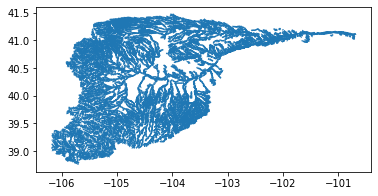

In [14]:
# Checking flowlines
# flowlines_test.head(3)            # see the first 3 rows
# type(flowlines_test.streamorder)  # check data type
# print(len(flowlines_test))        # check length
# set(flowlines_test.streamorder)   # list unique streamorder values

# Cleanup columns
imp_cols2 = ['OBJECTID', 'COMID', 'Reachcode', 'streamorder', 'geometry', 'Hydroseq', 'UpHydroseq', 'DnHydroseq']  # specify columns we want to keep
flowlines_test = flowlines_test[imp_cols2]  # filter dataframe with specified columns
# print(flowlines_test)

# Plotting
flowlines_test[flowlines_test.streamorder>0].plot()  # Plot all stream lines

## 4. Join the two datasets (NHD and NABD)
Check [this link](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/spatial-joins-in-python-geopandas-shapely/) out for help: 

See also: https://geopandas.org/mergingdata.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

### 4.1 Read NABD and plot

In [5]:
# Read in NABD shapefile
nabd = gp.read_file(gdrive/"nabd_fish_barriers_2012.shp")  # read in NABD from Drive
imp_cols3 = ['NIDID', 'COMID', 'Dam_name', 'Purposes', 'Year_compl', 'Norm_stor', 'geometry']  # specify columns we want to keep
nabd = nabd[imp_cols3]  # filter dataframe with specified columns
print(list(nabd.columns))
# print(len(nabd))

['NIDID', 'COMID', 'Dam_name', 'Purposes', 'Year_compl', 'Norm_stor', 'geometry']


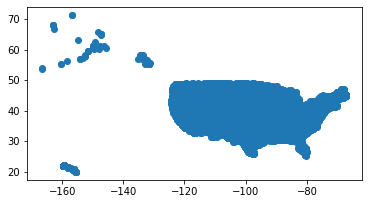

In [6]:
# Plotting check
nabd[nabd.COMID>0].plot()  # plot all dams in US

### 4.2 Merge datasets by COMID

In [7]:
# Merge NABD and NHD
nabd_nhd_join = nabd.merge(flowlines_test, how= 'right', on='COMID')  # how = 'right': merge is done by adding NABD attributes to NHD flowlines based on COMID
                                                                 # the result will have the same length as "flowlines_test"

### 4.3 Checks of 'nabd_nhd_join'

In [8]:
# Checking stuff after merge
# nabd_nhd_join.head(3)  
# nabd_nhd_join.columns
# set(nabd_nhd_join)
# type(nabd_nhd_join)
# print(len(nabd_nhd_join))  #check the merge
# print(type(nabd_nhd_join))
# print(nabd_nhd_join[nabd_nhd_join.NIDID!='NaN'])

# Plotting  *currently not working, but does not matter*
# nabd_nhd_join[nabd_nhd_join.NIDID!='nan'].plot()
# nabd_nhd_join[nabd_nhd_join.COMID>0].plot()
# nabd_nhd_join[nabd_nhd_join.streamorder>0].plot(subplots=FALSE)

## 5. How to read in NHDFlowline csv
Exported the Flowline_Network feature class in the NHDPlusV21_National_Seamless_Flattened_Lower48 geodatabase to a csv. [This link](https://gis.stackexchange.com/questions/23376/how-to-export-polygons-to-csv-with-coordinates) helped me keep the geometry of the flowlines

In [9]:
# Flowline csv
nhdflowlines = pd.read_csv(gdrive/"NHDPlusNationalData/NHDFlowlines.csv")
nhdflowlines.head(3)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (137) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,WKT,OBJECTID,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,...,QC_12,VC_12,QE_12,VE_12,LakeFract,SurfArea,RAreaHLoad,RPUID,VPUID,Enabled
0,MULTILINESTRING ZM ((-69.0801710698805 47.0479...,1,721640,2008-08-28T00:00:00.000,Medium,561174,Allagash River,7.634,1010002000001,With Digitized,...,1263.340,1.79598,1230.971,1.66764,NaN,NaN,NaN,01a,1,1
1,MULTILINESTRING ZM ((-69.0452752699346 47.0841...,2,717072,2008-08-28T00:00:00.000,Medium,561174,Allagash River,0.948,1010002000001,With Digitized,...,1263.974,0.95148,1231.605,0.89602,NaN,NaN,NaN,01a,1,1
2,MULTILINESTRING ZM ((-69.075266469888 47.02969...,3,717076,2008-08-28T00:00:00.000,Medium,561174,Allagash River,2.151,1010002000001,With Digitized,...,1253.339,1.69117,1252.634,1.68824,NaN,NaN,NaN,01a,1,1


In [10]:
### 5.1 Checking and filtering the csv

In [11]:
# list(flowlines.columns)
keep_cols = ['OBJECTID', 'COMID', 'REACHCODE', 'StreamOrde', 'WKT', 'Hydroseq', 'UpHydroseq', 'DnHydroseq']  # specify columns we want to keep
nhdflowlines = nhdflowlines[keep_cols] # filter dataframe with specified columns
nhdflowlines.head(3)
# nhdflowlines['REACHCODE']
# nhdflowlines['WKT']

,OBJECTID,COMID,REACHCODE,StreamOrde,WKT,Hydroseq,UpHydroseq,DnHydroseq
0,1,721640,1010002000001,5,MULTILINESTRING ZM ((-69.0801710698805 47.0479...,150003787,150003801,150003773
1,2,717072,1010002000001,5,MULTILINESTRING ZM ((-69.0452752699346 47.0841...,150003773,150003787,150003451
2,3,717076,1010002000001,5,MULTILINESTRING ZM ((-69.075266469888 47.02969...,150003801,150003816,150003787
